# Why do we want a Bayesian Model?

Standard vs. Bayesian models:
- Standard neural networks provide point estimates of the weights
    - these models are deterministic
- Bayesian models integrate over various settings of the weights
    - this intergration is done via MC sampling - drawing weights from a distribution and averaging over these draws
    
What do Bayesian models provide?
- The distribution over the output allows us to measure uncertainty
- In a classification example, the Bayesian model provides a distribution over categorical distributions
- Deterministic models tend to be overconfident in their (incorrect) predictions, whereas Bayesian models capture the uncertainty in their decisions

The following notebook plots figures to show that Bayesian models provide more uncertain estimates than deterministic models when their predictions are incorrect.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from toolbox import load_dataset
from keras.models import load_model

/remote/mlsalt-2017/lrc45/Envs/concretedropout/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# dataset = 'svhn' 
# dataset = 'mnist'
dataset = 'cifar10'

In [3]:
det_model_path = '../../models/deterministic/saved_models/{}-cnn-run1/model.h5'.format(dataset)
bayes_model_path = '../../models/bbalpha/keras/saved_models/{}-cnn-alpha0.5-run1/model-test.h5'.format(dataset)

In [4]:
det_model = load_model(det_model_path)
bayes_model = load_model(bayes_model_path)

/remote/mlsalt-2017/lrc45/Envs/concretedropout/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
_, _, test = load_dataset.load_image_data(dataset, channels_first=False)

In [6]:
det_model_output = det_model.predict(test[0])
det_model_acc = np.argmax(det_model_output, axis=-1) == np.argmax(test[1], axis=-1)
det_model_incorrect_points = np.where(det_model_acc == 0)[0]
det_model_correct_points = np.where(det_model_acc == 1)[0]
np.mean(det_model_acc)

0.7287

In [7]:
bayes_model_output = bayes_model.predict(test[0])
bayes_model_predictions = np.mean(bayes_model_output, axis=1)
bayes_model_acc = np.argmax(bayes_model_predictions, axis=-1) == np.argmax(test[1], axis=-1)
bayes_model_incorrect_points = np.where(bayes_model_acc == 0)[0]
bayes_model_correct_points = np.where(bayes_model_acc == 1)[0]
np.mean(bayes_model_acc)

0.7144

In [8]:
intersection_incorrect_points = np.array(list(set(bayes_model_incorrect_points) & set(det_model_incorrect_points)))
intersection_correct_points = np.array(list(set(bayes_model_correct_points) & set(det_model_correct_points)))

In [9]:
det_model_max_softmax = np.max(det_model_output[intersection_incorrect_points], axis=1)
bayes_model_max_softmax = np.max(bayes_model_predictions[intersection_incorrect_points], axis=1)

In [10]:
det_model_entropy = - np.sum(det_model_output[intersection_incorrect_points] 
                           * np.log2(det_model_output[intersection_incorrect_points]),
                           axis=1)
bayes_model_entropy = - np.sum(bayes_model_predictions[intersection_incorrect_points] 
                           * np.log2(bayes_model_predictions[intersection_incorrect_points]),
                           axis=1)

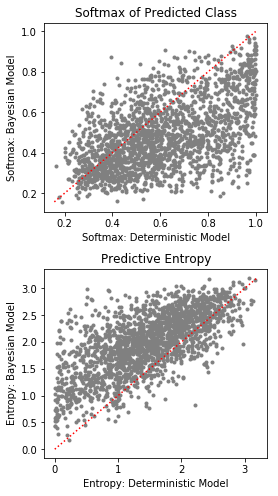

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 8))
ax1.scatter(det_model_max_softmax, bayes_model_max_softmax, marker='.', color=[0.5, 0.5, 0.5])
combined = np.concatenate((det_model_max_softmax,  bayes_model_max_softmax))
ranges = (np.min(combined), np.max(combined))
ax1.set_xlabel('Softmax: Deterministic Model')
ax1.set_ylabel('Softmax: Bayesian Model')
ax1.set_title('Softmax of Predicted Class')
ax1.plot(ranges, ranges, 'r:')
ax2.scatter(det_model_entropy, bayes_model_entropy, marker='.', color=[0.5, 0.5, 0.5])
combined = np.concatenate((det_model_entropy,  bayes_model_entropy))
ranges = (np.min(combined), np.max(combined))
ax2.plot(ranges, ranges, 'r:')
ax2.set_xlabel('Entropy: Deterministic Model')
ax2.set_ylabel('Entropy: Bayesian Model')
ax2.set_title('Predictive Entropy')
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
f.savefig('{}.png'.format(dataset), dpi=600)